In [187]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

import os
from datetime import datetime, timedelta

from rakott.mpl import fig_panel_labels, fig_xlabel, fig_ylabel, savefig_bbox

In [122]:
def int_to_dt(t):
    return pd.to_datetime(start_date) + timedelta(days=t)
def date_to_int(x):
    dt = datetime.strptime(x + ' 2020', '%b %d %Y')
    td = dt - start_date
    return td.days
def date_to_date(x):
    dt = datetime.strptime(x + ' 2020', '%b %d %Y')
    return dt
# from plot_utils.py
def τ_to_string(τ):
    return (pd.to_datetime(start_date) + timedelta(days=τ)).strftime('%b %d')
from inference import simulate
def generate(Z, D, μ, β1, α1, λ, α2, E0, Iu0, τ, ndays, N, Td1=9, Td2=6):
    τ = int(τ)
    S, E, Ir, Iu, R, Y = simulate(Z, D, μ, β1, α1, λ, α2, E0, Iu0, τ, ndays,N)
    p1 = 1/Td1
    p2 = 1/Td2 
    C = np.zeros_like(Y)
    for t in range(1, len(C)):
        p = p1 if t < τ else p2
        n = Y[t] - C[:t].sum()
        n = max(0,n)
        C[t] = np.random.poisson(n * p)     
    return C

# from inference.py
def find_start_day(cases_and_dates):
    #looks for the last 0 0 sequence pattern
    arr = np.array(cases_and_dates['cases'])
    ind = len(arr)-list(zip(arr, arr[1:]))[::-1].index((0,0))
    # return cases_and_dates.iloc[ind-1]['date']
    return cases_and_dates.iloc[ind-1]['date']

In [105]:
job_id = '2020-04-30-prior-walkers-model2-normal'
country = 'Italy'

output_folder = os.path.join('..', 'output', job_id)
table_path = os.path.join(output_folder, 'tables', 'all-countries-{}.csv'.format(job_id))
df = pd.read_csv(table_path)
df = df.rename(columns={'official_τ': 'τ official'})
df['country'] = df['country'].str.replace("_", " ")
df = df[df['country'] == country]
print(df.columns)
df

Index(['country', 'DIC', 'MAP loglik', 'N', 'p_steps', 'p_τ_model', 'p_Td1',
       'p_Td2', 'τ official', 'τ mean', 'τ median', 'τ CI (75%)', 'Z mean',
       'Z median', 'D mean', 'D median', 'μ mean', 'μ median', 'β mean',
       'β median', 'α1 mean', 'α1 median', 'λ mean', 'λ median', 'α2 mean',
       'α2 median', 'E0 mean', 'E0 median', 'Iu0 mean', 'Iu0 median',
       'τ mean.1', 'τ median.1'],
      dtype='object')


,country,DIC,MAP loglik,N,p_steps,p_τ_model,p_Td1,p_Td2,τ official,τ mean,...,λ mean,λ median,α2 mean,α2 median,E0 mean,E0 median,Iu0 mean,Iu0 median,τ mean.1,τ median.1
9,Italy,-1229.95,-868.61,60431283,100000,TauModel.wide_prior,9,6,Mar 10,Mar 14,...,0.48,0.47,0.56,0.55,1130.08,1060.22,1991.2,2076.2,22.9,24.49


In [151]:
Z, D, μ, β, α, _, _, E0, Iu0, τ = df[['Z median', 'D median', 'μ median', 'β median', 'α1 median', 'λ median', 'α2 median', 'E0 median', 'Iu0 median', 'τ median.1']].values[0].tolist()
τ_star_days = date_to_int(df['τ official'].values[0])

In [152]:
url = 'https://github.com/ImperialCollegeLondon/covid19model/raw/v1.0/data/COVID-19-up-to-date.csv'
fname = '../data/COVID-19-up-to-date.csv'
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
data = pd.read_csv(fname, encoding='iso-8859-1')
data['date'] = pd.to_datetime(data['dateRep'], format='%d/%m/%Y')
data = data[data['countriesAndTerritories'] == country]
N = data.iloc[0]['popData2018']
cases_and_dates = data.iloc[::-1][['cases','date']]
start_date = find_start_day(cases_and_dates)
X = np.array(cases_and_dates[cases_and_dates['date'] >= start_date]['cases'])
ndays = len(X)

In [153]:
y = generate(Z, D, μ, β, α, 0.5, α, E0, Iu0, τ, ndays, N)
y_star = generate(Z, D, μ, β, α, 0.5, α, E0, Iu0, τ_star_days, ndays, N)
ylow, yhigh = scipy.stats.poisson(y).interval(0.95)
y_starlow, y_starhigh = scipy.stats.poisson(y_star).interval(0.95)

In [154]:
X_mean = scipy.signal.savgol_filter(X, 3, 1)

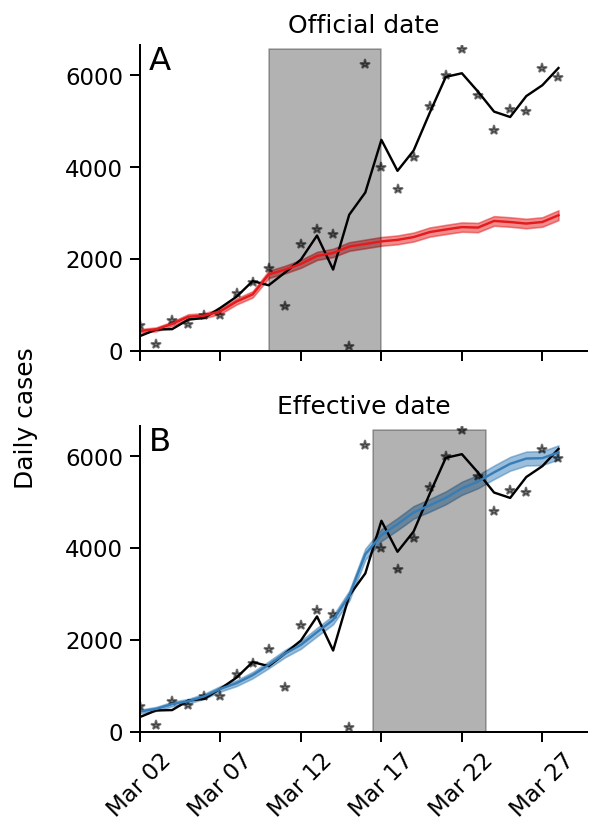

In [208]:
max_vline = 0.9
ymax = X.max()

fig, axes = plt.subplots(2, 1, figsize=(4, 6), sharex=True, sharey=True)

t = range(0, ndays)
for ax in axes.flat:
    ax.plot(t, X, '*', color='k', alpha=0.5)
    ax.plot(t, X_mean, '-', color='k')

ax = axes[0]
ax.set_title('Official date')
ax.plot(t, y_star, color=red)
ax.fill_between(t, y_starlow, y_starhigh, color=red, alpha=0.5)
# ax.axvline(τ_star_days, ymax=max_vline, color=red,   ls='-', lw=3)
# ax.axvline(τ_star_days+7, ymax=max_vline, color=red,   ls='-', lw=3)
ax.fill_between([τ_star_days, τ_star_days+7], 0, ymax, color='k', alpha=0.3)

ax = axes[1]
ax.set_title('Effective date')
ax.plot(t, y, color=blue)
ax.fill_between(t, ylow, yhigh, color=blue, alpha=0.5)
# ax.axvline(τ, ymax=max_vline, color=blue, ls='-', lw=3)
# ax.axvline(τ+7, ymax=max_vline, color=blue, ls='-', lw=3)
ax.fill_between([τ, τ+7], 0, ymax, color='k', alpha=0.3)

labels = [τ_to_string(d) for d in t[::5]]
ax.set_xticks(days)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlim(10, None)
ax.set_ylim(0, ymax+100)
txt = fig_ylabel(fig, 'Daily cases')

fig.tight_layout()
# fig.suptitle(country)
fig_panel_labels(axes, xcoord=0.02)
sns.despine()
fig.savefig('../figures/fig4.pdf', dpi=100, **savefig_bbox(txt))